In [434]:
# Importing libraries

#Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Libraries for generic model building and reporting
from sklearn import metrics
from sklearn.model_selection  import train_test_split
from scipy.stats import zscore
from scipy.spatial.distance import cdist, pdist

# Part 1
#Libraries for clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

# Part 3
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Part 4
from sklearn.linear_model import LinearRegression

# PART 1 : Clustering and Regression on Automobile Data

* Goal 1 : Identify optimal number of clusters in the data using - Kmeans and Hierarchical clustering techniques
* Goal 2 : Use linear regression modelling on individual clusters to predict mpg

### Import and warehouse data

In [435]:
# Importing car names available in csv file
car_name = pd.read_csv("Part1 - Car name.csv")
car_name.head(5)

car_name
0  chevrolet chevelle malibu
1          buick skylark 320
2         plymouth satellite
3              amc rebel sst
4                ford torino

In [436]:
# Importing car attributes available in json file
car_attr = pd.read_json("Part1 - Car-Attributes.json")
car_attr.head(5)

mpg  cyl   disp   hp    wt   acc  yr  origin
0  18.0    8  307.0  130  3504  12.0  70       1
1  15.0    8  350.0  165  3693  11.5  70       1
2  18.0    8  318.0  150  3436  11.0  70       1
3  16.0    8  304.0  150  3433  12.0  70       1
4  17.0    8  302.0  140  3449  10.5  70       1

In [437]:
print(car_name.shape)
print(car_attr.shape)

(398, 1)
(398, 8)


In [438]:
# Concatenating the two dataframes
car_data = pd.concat([car_name, car_attr],axis=1)
car_data.head(5)

car_name   mpg  cyl   disp   hp    wt   acc  yr  origin
0  chevrolet chevelle malibu  18.0    8  307.0  130  3504  12.0  70       1
1          buick skylark 320  15.0    8  350.0  165  3693  11.5  70       1
2         plymouth satellite  18.0    8  318.0  150  3436  11.0  70       1
3              amc rebel sst  16.0    8  304.0  150  3433  12.0  70       1
4                ford torino  17.0    8  302.0  140  3449  10.5  70       1

In [439]:
print(car_data.shape)

(398, 9)


In [440]:
# Exporting data to local in all three file formats
car_data.to_csv("Car Data.csv")
car_data.to_json("Car Data.json")
car_data.to_excel("Car Data.xlsx")

In [441]:
# Importing the saved file for further processing
Car_raw_data = pd.read_csv("Car Data.csv")
Car_raw_data.head()
Car_raw_data = Car_raw_data.drop(["Unnamed: 0"],axis=1)

### Data cleansing

In [442]:
# Check for null values
Car_raw_data.isnull().values.any()

False

In [443]:
Car_raw_data.describe()

mpg         cyl        disp           wt         acc  \
count  398.000000  398.000000  398.000000   398.000000  398.000000   
mean    23.514573    5.454774  193.425879  2970.424623   15.568090   
std      7.815984    1.701004  104.269838   846.841774    2.757689   
min      9.000000    3.000000   68.000000  1613.000000    8.000000   
25%     17.500000    4.000000  104.250000  2223.750000   13.825000   
50%     23.000000    4.000000  148.500000  2803.500000   15.500000   
75%     29.000000    8.000000  262.000000  3608.000000   17.175000   
max     46.600000    8.000000  455.000000  5140.000000   24.800000   

               yr      origin  
count  398.000000  398.000000  
mean    76.010050    1.572864  
std      3.697627    0.802055  
min     70.000000    1.000000  
25%     73.000000    1.000000  
50%     76.000000    1.000000  
75%     79.000000    2.000000  
max     82.000000    3.000000

In [444]:
Car_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    object 
 1   mpg       398 non-null    float64
 2   cyl       398 non-null    int64  
 3   disp      398 non-null    float64
 4   hp        398 non-null    object 
 5   wt        398 non-null    int64  
 6   acc       398 non-null    float64
 7   yr        398 non-null    int64  
 8   origin    398 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


Comment : hp data type is object. It is expected to be numeric (int/float), so probabaly there are some unexpected characters 

In [445]:
# Identifying the rows that are not digits in the hp column
test = pd.DataFrame(Car_raw_data.hp.str.isdigit()) 
test[test['hp'] == False]

hp
32   False
126  False
330  False
336  False
354  False
374  False

In [446]:
# Replacing the data with nan
Car_raw_data = Car_raw_data.replace('?', np.nan)
Car_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    object 
 1   mpg       398 non-null    float64
 2   cyl       398 non-null    int64  
 3   disp      398 non-null    float64
 4   hp        392 non-null    object 
 5   wt        398 non-null    int64  
 6   acc       398 non-null    float64
 7   yr        398 non-null    int64  
 8   origin    398 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [447]:
# Converting the column data type to float
Car_raw_data['hp'] = Car_raw_data['hp'].astype('float64')

In [448]:
# Replacing the nan with median of the column
numeric_cols = Car_raw_data.drop('car_name', axis=1)
car_names = pd.DataFrame(Car_raw_data[['car_name']])
numeric_cols = numeric_cols.apply(lambda x: x.fillna(x.median()),axis=0)

# Recreating Car_raw_data by combining numerical columns with car names
Car_raw_data = numeric_cols.join(car_names) 
Car_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mpg       398 non-null    float64
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    float64
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   origin    398 non-null    int64  
 8   car_name  398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


#### Comment : The dataset is now ready for further analysis , free of any missing values

### Data analysis and visualisation

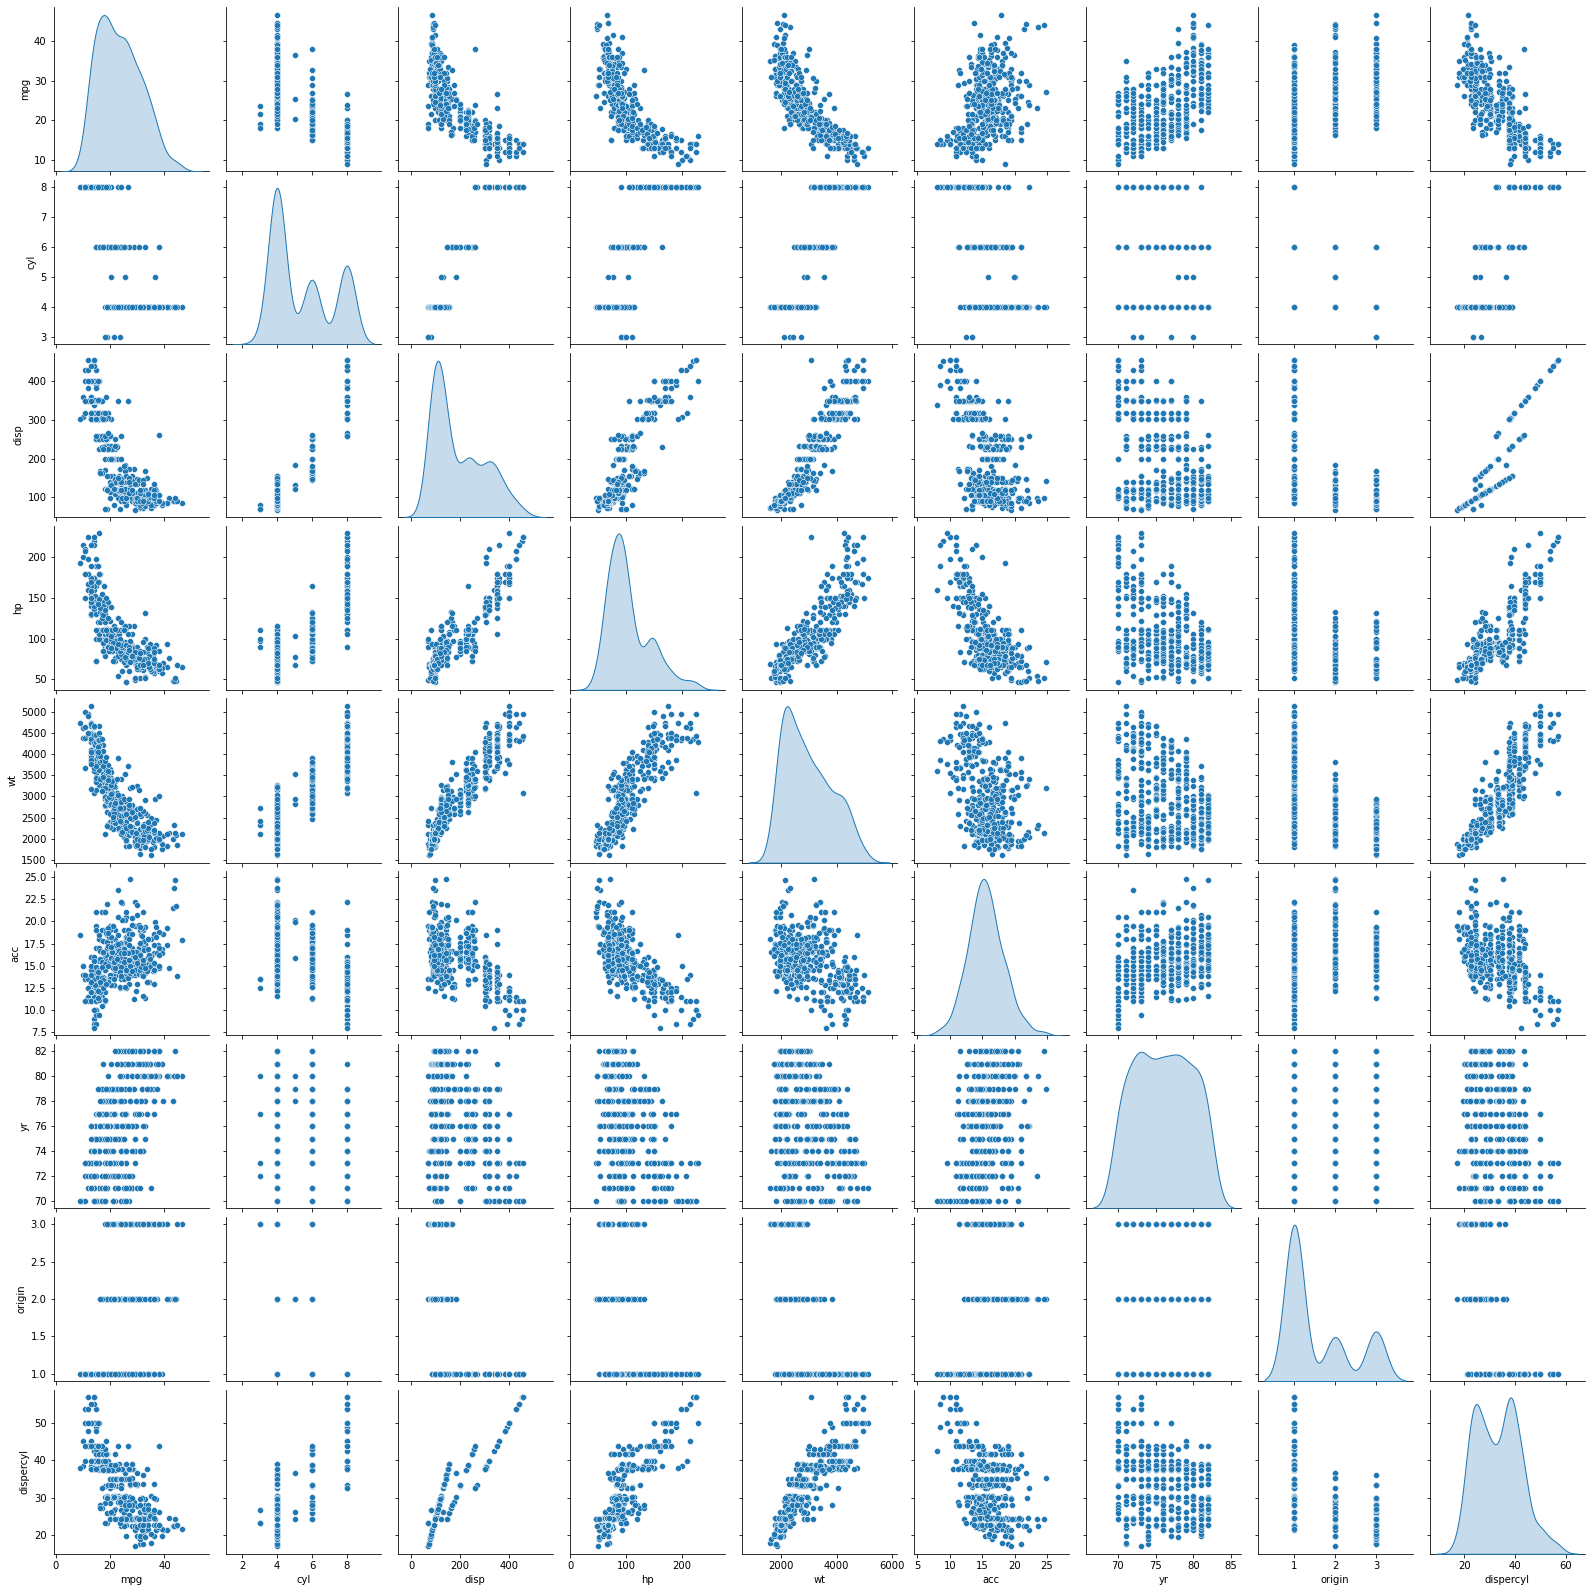

In [449]:
# This is done using scatter matrix function which creates a dashboard reflecting useful information about the dimensions
# The result can be stored as a .png file and opened in say, paint to get a larger view 

car_df_attr = Car_raw_data.iloc[:, 0:8]
car_df_attr['dispercyl'] = car_df_attr['disp'] / car_df_attr['cyl']
sns.pairplot(car_df_attr, diag_kind='kde') 

#### Comment : Overall we see 3 peaks in the data distribution, indicating possibly 3 clusters

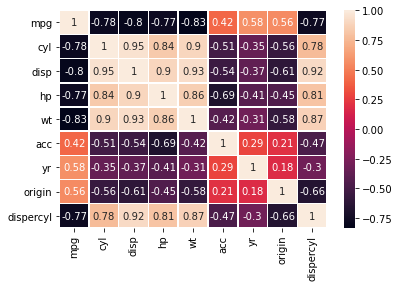

In [450]:
# Getting the correlation matrix 
ax = sns.heatmap(car_df_attr.corr(), annot = True, linewidth=0.5)
plt.show()

#### Comment : High (negative) correlation of the mpg variable with cyl, disp, hp and wt variables

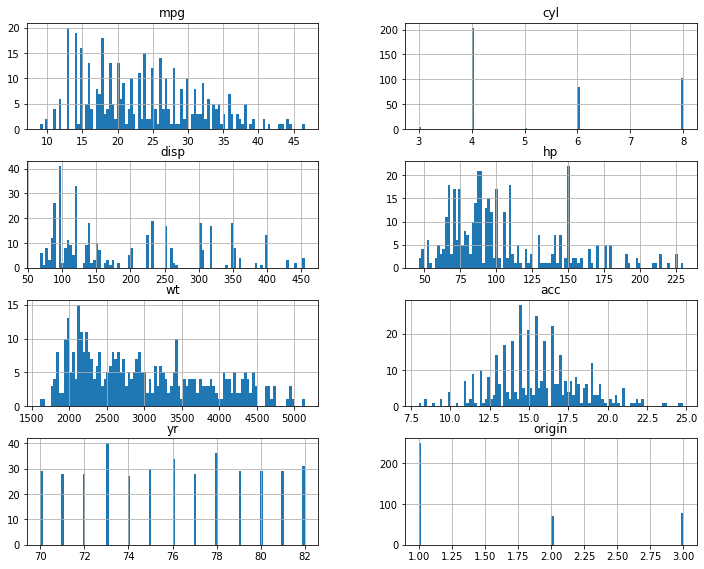

In [451]:
# Histogram of continuous columns
columns = list(car_df_attr)[0:-1] # Excluding car_name column which is a category
car_df_attr[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(12,2)); 

<AxesSubplot:>

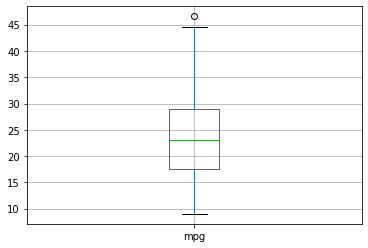

In [452]:
car_df_attr.boxplot(column = "mpg")

<AxesSubplot:>

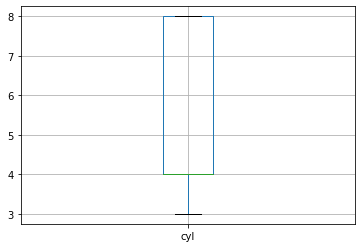

In [453]:
car_df_attr.boxplot(column = "cyl")

<AxesSubplot:>

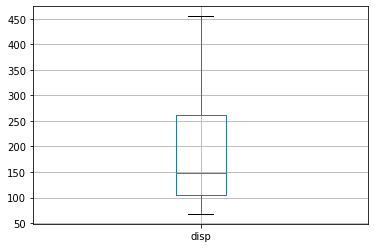

In [454]:
car_df_attr.boxplot(column = "disp")

<AxesSubplot:>

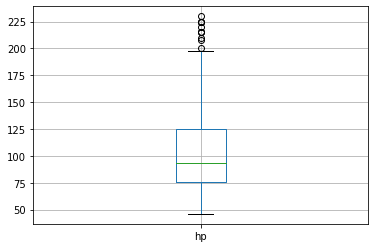

In [455]:
car_df_attr.boxplot(column = "hp")

<AxesSubplot:>

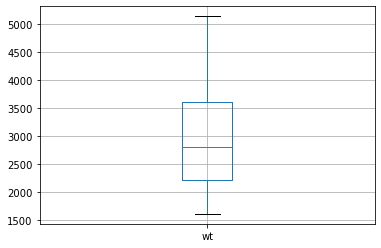

In [456]:
car_df_attr.boxplot(column = "wt")

<AxesSubplot:>

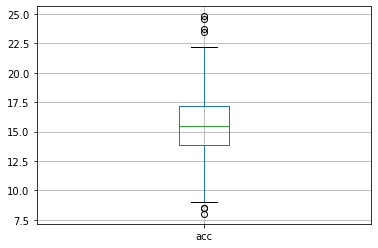

In [457]:
car_df_attr.boxplot(column = "acc")

<AxesSubplot:>

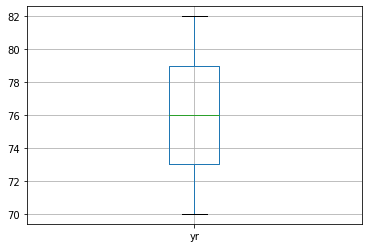

In [458]:
car_df_attr.boxplot(column = "yr")

#### Comment : Few outliers in columns like - hp, acc and mpg

### Regression model before performing clustering

In [459]:
car_df_attr.head(3)

mpg  cyl   disp     hp    wt   acc  yr  origin  dispercyl
0  18.0    8  307.0  130.0  3504  12.0  70       1     38.375
1  15.0    8  350.0  165.0  3693  11.5  70       1     43.750
2  18.0    8  318.0  150.0  3436  11.0  70       1     39.750

In [460]:
# Building linear model on original data
car_df_attr_z = car_df_attr.apply(zscore)

car_df_attr_z.pop('origin')      
car_df_attr_z.pop('yr')

array = car_df_attr_z.values
X = array[:,1:5] # select all rows and first 7 columns which are the attributes
y = array[:,0]   # select all rows and the 8th column which is the classification "Yes", "No" for diabeties
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [461]:
car_df_attr_z

mpg       cyl      disp        hp        wt       acc  dispercyl
0   -0.706439  1.498191  1.090604  0.673118  0.630870 -1.295498   0.577426
1   -1.090751  1.498191  1.503514  1.589958  0.854333 -1.477038   1.196926
2   -0.706439  1.498191  1.196232  1.197027  0.550470 -1.658577   0.735902
3   -0.962647  1.498191  1.061796  1.197027  0.546923 -1.295498   0.534205
4   -0.834543  1.498191  1.042591  0.935072  0.565841 -1.840117   0.505391
..        ...       ...       ...       ...       ...       ...        ...
393  0.446497 -0.856321 -0.513026 -0.479482 -0.213324  0.011586   0.188437
394  2.624265 -0.856321 -0.925936 -1.370127 -0.993671  3.279296  -1.050564
395  1.087017 -0.856321 -0.561039 -0.531873 -0.798585 -1.440730   0.044367
396  0.574601 -0.856321 -0.705077 -0.662850 -0.408411  1.100822  -0.387842
397  0.958913 -0.856321 -0.714680 -0.584264 -0.296088  1.391285  -0.416656

[398 rows x 7 columns]

In [462]:
from sklearn import svm
clr = svm.SVR()  
clr.fit(X_train , y_train)

SVR()

In [463]:
y_pred = clr.predict(X_test)
clr.score(X_train, y_train)

0.7528775476102794

In [464]:
clr.score(X_test, y_test)

0.7872884170162794

### Machine Learning : K-means Clustering

In [465]:
 # expect 3 to 4 clusters from the pair panel visual inspection hence restricting from 2 to 10
cluster_range = range( 2, 10 )  
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(car_df_attr_z)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

num_clusters  cluster_errors
0             2     1128.751974
1             3      754.572122
2             4      606.033608
3             5      524.926593
4             6      456.155367
5             7      408.611180
6             8      381.039987
7             9      357.522242

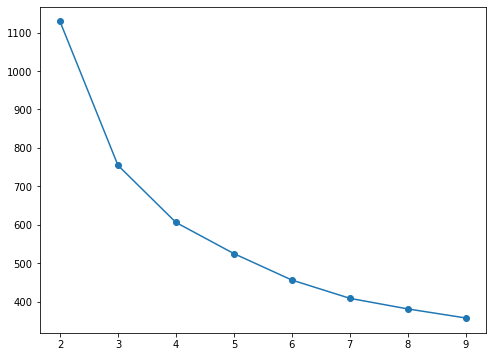

In [466]:
# Elbow plot

plt.figure(figsize=(8,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [467]:
cluster = KMeans( n_clusters = 4, random_state = 2412 )
cluster.fit(car_df_attr_z)

prediction=cluster.predict(car_df_attr_z)
car_df_attr_z["K_means_Group"] = prediction     # Creating a new column "K_means_Group" which will hold the cluster id of each record

car_df_attr_z_copy = car_df_attr_z.copy(deep = True)  # Creating a mirror copy for later re-use instead of building repeatedly

In [468]:
centroids = cluster.cluster_centers_
centroids

array([[ 1.18309492, -0.84055375, -0.93541044, -0.92141313, -1.00510422,
         0.65183642, -1.09765205],
       [-1.15110476,  1.4860546 ,  1.48450715,  1.50624078,  1.38753374,
        -1.06267868,  1.17984547],
       [-0.49915721,  0.37057867,  0.33477714, -0.12568564,  0.36824696,
         0.49452436,  0.48082362],
       [ 0.19415641, -0.76191797, -0.63224271, -0.3063696 , -0.49607168,
        -0.10350348, -0.29638058]])

In [471]:
# centroid_df = pd.DataFrame(centroids, columns = list(car_df_attr) )
# centroid_df

array([[<AxesSubplot:title={'center':'acc'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'cyl'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'disp'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'dispercyl'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'hp'}, xlabel='[K_means_Group]'>],
       [<AxesSubplot:title={'center':'mpg'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'wt'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

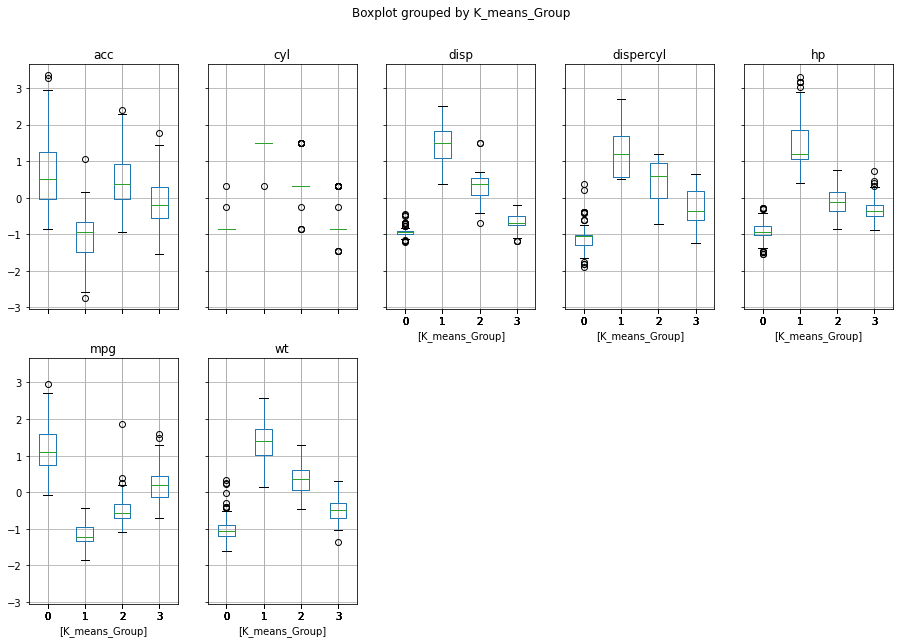

In [472]:
car_df_attr_z.boxplot(by = 'K_means_Group',  layout=(2,5), figsize=(15, 10))

In [473]:
data = car_df_attr_z  
       
def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median()       
    return group

data_corrected = (data.groupby('K_means_Group').transform(replace)) 
concat_data = data_corrected.join(pd.DataFrame(car_df_attr_z['K_means_Group']))

array([[<AxesSubplot:title={'center':'acc'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'cyl'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'disp'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'dispercyl'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'hp'}, xlabel='[K_means_Group]'>],
       [<AxesSubplot:title={'center':'mpg'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:title={'center':'wt'}, xlabel='[K_means_Group]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

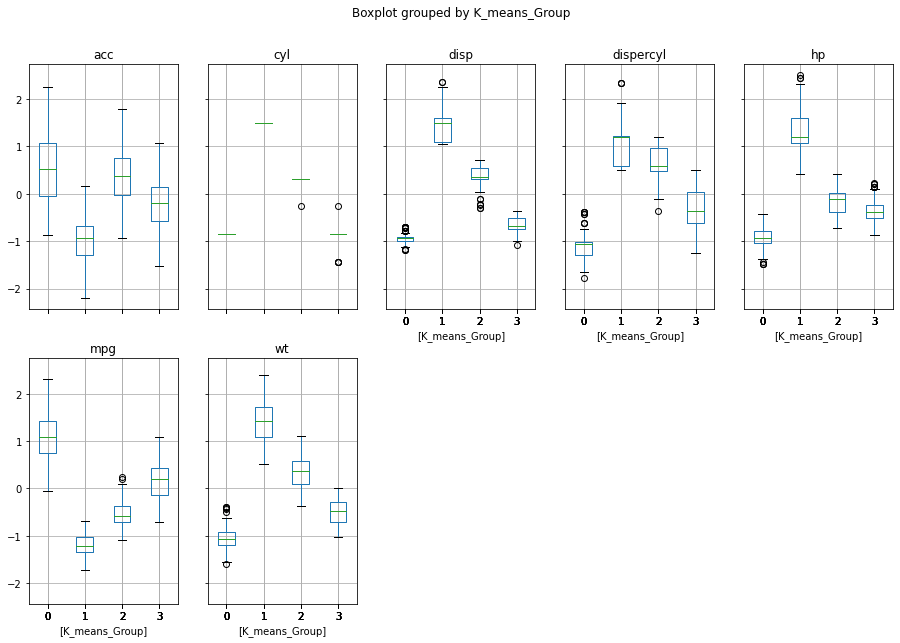

In [474]:
concat_data.boxplot(by = 'K_means_Group', layout=(2,5), figsize=(15, 10))

### Machine Learning : Hierarchical CLustering

In [475]:
# Building the model
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')
model.fit(car_df_attr_z)

#Adding the column with generated class labels
car_df_attr_z['Hierr_Group'] = model.labels_
car_df_attr_z.head(10)

mpg       cyl      disp        hp        wt       acc  dispercyl  \
0 -0.706439  1.498191  1.090604  0.673118  0.630870 -1.295498   0.577426   
1 -1.090751  1.498191  1.503514  1.589958  0.854333 -1.477038   1.196926   
2 -0.706439  1.498191  1.196232  1.197027  0.550470 -1.658577   0.735902   
3 -0.962647  1.498191  1.061796  1.197027  0.546923 -1.295498   0.534205   
4 -0.834543  1.498191  1.042591  0.935072  0.565841 -1.840117   0.505391   
5 -1.090751  1.498191  2.262118  2.454408  1.620492 -2.021656   2.335078   
6 -1.218855  1.498191  2.502182  3.030708  1.635863 -2.384735   2.695252   
7 -1.218855  1.498191  2.367746  2.899730  1.586204 -2.566274   2.493554   
8 -1.218855  1.498191  2.511784  3.161685  1.719809 -2.021656   2.709659   
9 -1.090751  1.498191  1.887617  2.244844  1.039961 -2.566274   1.773205   

   K_means_Group  Hierr_Group  
0              1            1  
1              1            1  
2              1            1  
3              1            1  
4              1            1  
5              1            1  
6              1            1  
7              1            1  
8              1            1  
9              1            1

In [476]:
# Finding the distribution of the two classes
Car_Clust = car_df_attr_z.groupby(['Hierr_Group'])
Car_Clust.mean()

mpg       cyl      disp        hp        wt       acc  \
Hierr_Group                                                               
0           -0.110315 -0.264578 -0.207573 -0.227022 -0.116503  0.159123   
1           -1.151105  1.486055  1.484507  1.506241  1.387534 -1.062679   
2            1.192761 -0.840267 -0.943701 -0.921351 -1.028744  0.612646   
3            0.651463 -0.856321 -0.479417 -0.924805  0.295084  2.807293   

             dispercyl  K_means_Group  
Hierr_Group                            
0             0.044931       2.560847  
1             1.179845       1.000000  
2            -1.122869       0.000000  
3             0.289286       0.000000

In [477]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(car_df_attr_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(car_df_attr_z))

c

0.8434954289678188

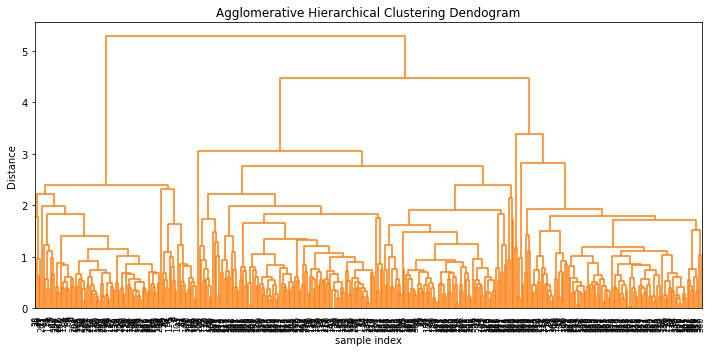

In [478]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

#### Comparing 'mpg' with other dependent variables

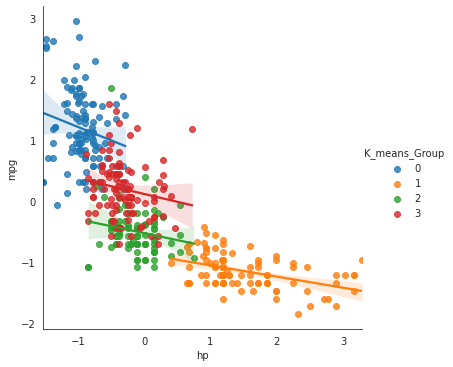

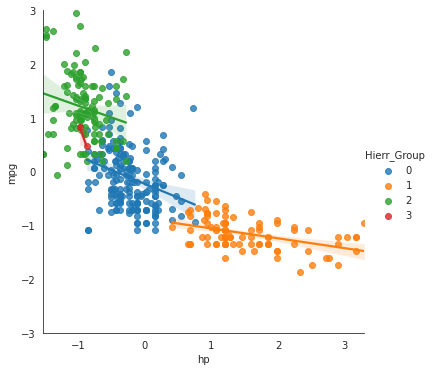

In [479]:
# mpg Vs hp

var = 'hp'

with sns.axes_style("white"):
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='K_means_Group')
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='Hierr_Group')
plot.set(ylim = (-3,3))

# with sns.axes_style("white"):
#     plot = sns.lmplot(x=var,y='mpg',data=concat_data,hue='Hierr_Group')
# plot.set(ylim = (-3,3))

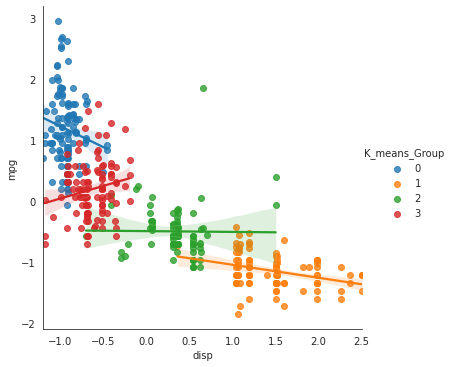

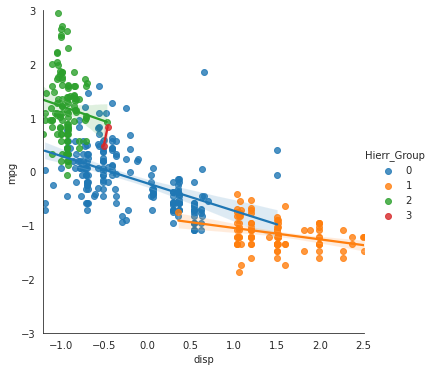

In [480]:
var = 'disp'
with sns.axes_style("white"):
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='K_means_Group')
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='Hierr_Group')
plot.set(ylim = (-3,3))

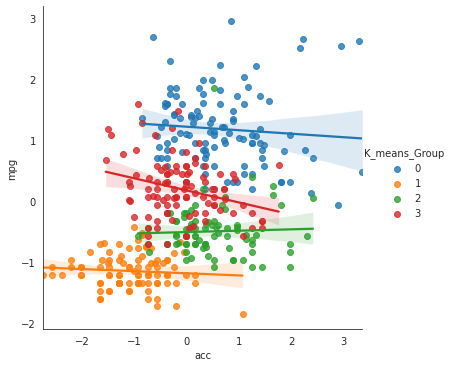

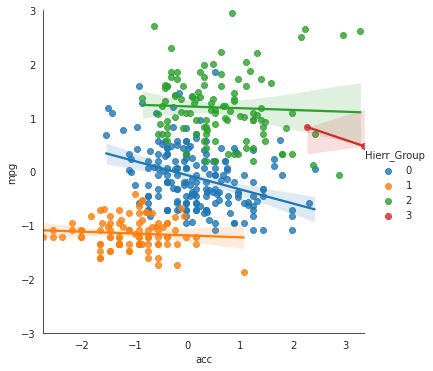

In [481]:
var = 'acc'
with sns.axes_style("white"):
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='K_means_Group')
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='Hierr_Group')
plot.set(ylim = (-3,3))

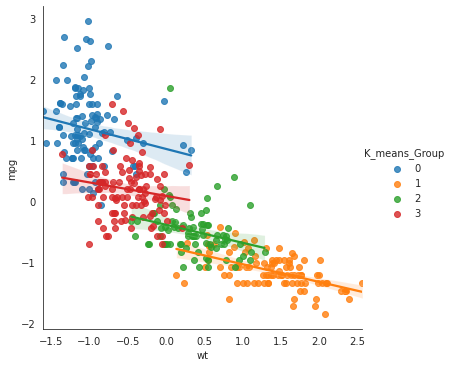

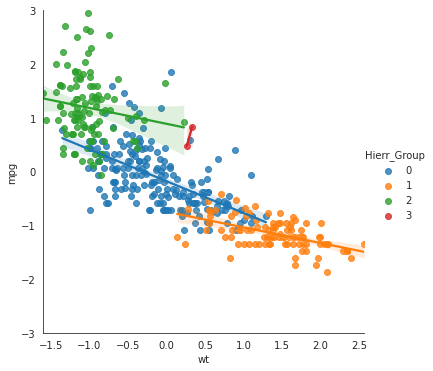

In [482]:
var = 'wt'
with sns.axes_style("white"):
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='K_means_Group')
    plot = sns.lmplot(x=var,y='mpg',data=car_df_attr_z,hue='Hierr_Group')
plot.set(ylim = (-3,3))

### Regression Modelling on Individual Clusters

In [483]:
# Let us break the data into largecar and smallcar segments

largecar = concat_data[concat_data['K_means_Group']==0]
smallcar = concat_data[concat_data['K_means_Group']==1]
sedancar = concat_data[concat_data['K_means_Group']==2]

In [484]:
X = sedancar.drop(['mpg','K_means_Group'], axis=1)
y = sedancar['mpg']

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 0.04045837843793865


In [486]:
regression_model.score(X_train, y_train)

0.4130594068191745

In [487]:
regression_model.score(X_test, y_test)

0.09327804010234464

# Part 2 : Synthetic data generation

In [488]:
# Importing the dataset and look into the available target variable
raw_data = pd.read_excel("Part2 - Company.xlsx")
raw_data['Quality'].unique()

array(['Quality A', 'Quality B', nan], dtype=object)

In [489]:
# Convert the target variable to categorical 1, 0, -1(null)
raw_data.Quality = pd.Categorical(pd.factorize(raw_data.Quality)[0])
print (raw_data)

      A    B    C    D Quality
0    47   27   45  108       0
1   174  133  134  166       1
2   159  163  135  131      -1
3    61   23    3   44       0
4    59   60    9   68       0
..  ...  ...  ...  ...     ...
56  200  186  185  179       1
57  137  182  165  199      -1
58   88   39    9  102      -1
59  180  157  192  198      -1
60  157  135  135  156      -1

[61 rows x 5 columns]


#### Comment 
* Using unsupervised clustering algorithms to predict classes

* The predicted classes will be compared with the available classes, and if pattern matches we replace the predicted classes with existing target column


In [490]:
# Dropping the target column
wine_ = raw_data.drop(['Quality'],axis=1)

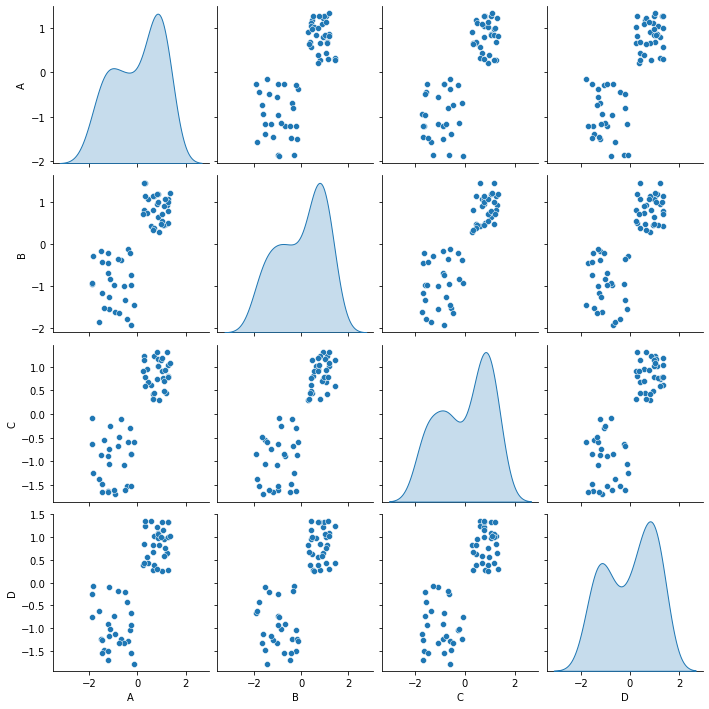

In [491]:
# Scaling the data before applying clustering mechanism
wine_scaled=wine_.apply(zscore)
sns.pairplot(wine_scaled,diag_kind='kde')

### Algorithm 1: Clustering using K-means

C:\Users\inannar\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

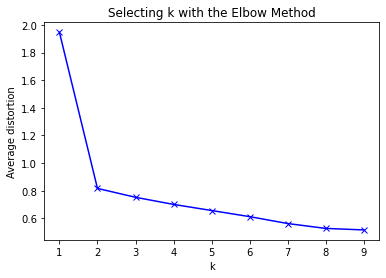

In [492]:
#Finding optimal no. of clusters
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(wine_scaled)
    prediction=model.predict(wine_scaled)
    meanDistortions.append(sum(np.min(cdist(wine_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / wine_scaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

#### Comment : It is quite evident from the graph that the optimum k value is k=2

In [493]:
# Building a k means model with k=2
final_model=KMeans(2)
final_model.fit(wine_scaled)
prediction=final_model.predict(wine_scaled)

In [494]:
#Append the prediction 
wine_["Kmean Group"] = prediction
wine_scaled["Kmean Group"] = prediction
print("Groups Assigned : \n")
wine_.head()

Groups Assigned : 



A    B    C    D  Kmean Group
0   47   27   45  108            0
1  174  133  134  166            1
2  159  163  135  131            1
3   61   23    3   44            0
4   59   60    9   68            0

In [495]:
# Finding the distribution of the two classes
wine_cluster1 = wine_.groupby(['Kmean Group'])
wine_cluster1.mean()

A           B           C           D
Kmean Group                                               
0             58.75000   60.928571   49.750000   53.000000
1            169.30303  163.909091  168.666667  166.606061

array([[<AxesSubplot:title={'center':'A'}, xlabel='[Kmean Group]'>,
        <AxesSubplot:title={'center':'B'}, xlabel='[Kmean Group]'>,
        <AxesSubplot:title={'center':'C'}, xlabel='[Kmean Group]'>,
        <AxesSubplot:title={'center':'D'}, xlabel='[Kmean Group]'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

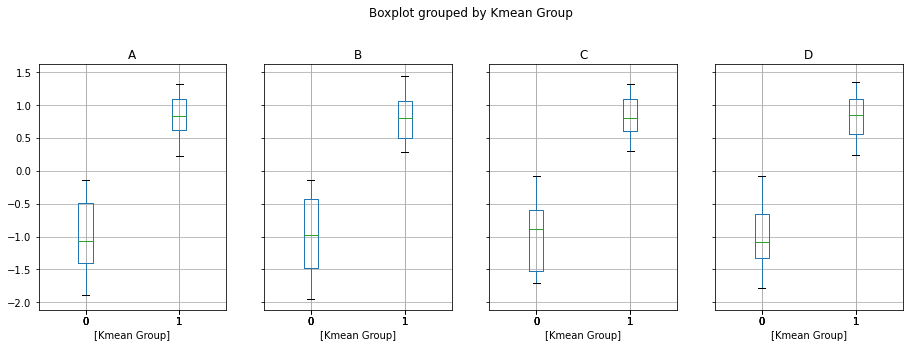

In [496]:
# Am overview of the two classes generated for each attributes
wine_scaled.boxplot(by='Kmean Group', layout = (2,4),figsize=(15,10))

###  Algorithm 2: Clustering using Hierarchical Cluster

In [497]:
# Building the model
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model.fit(wine_scaled)

AgglomerativeClustering(linkage='average')

In [498]:
#Adding the column with generated class labels
wine_['Hierr Group'] = model.labels_
wine_.head(10)

A    B    C    D  Kmean Group  Hierr Group
0   47   27   45  108            0            0
1  174  133  134  166            1            1
2  159  163  135  131            1            1
3   61   23    3   44            0            0
4   59   60    9   68            0            0
5  153  140  154  199            1            1
6   34   28   78   22            0            0
7  191  144  143  154            1            1
8  160  181  194  178            1            1
9  145  178  158  141            1            1

In [499]:
# Finding the distribution of the two classes
wine_cluster2 = wine_.groupby(['Hierr Group'])
wine_cluster2.mean()


A           B           C           D  Kmean Group
Hierr Group                                                            
0             58.75000   60.928571   49.750000   53.000000            0
1            169.30303  163.909091  168.666667  166.606061            1

#### Note : The model class identified by K mean -[1, 0] has a reverse nomenclature in Hierr Group - [0,1]

In [500]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(wine_scaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(wine_scaled))

c

0.9529493839226334

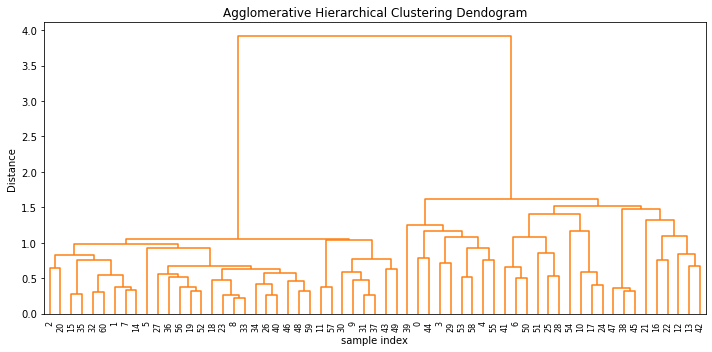

In [501]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

Confusion Matrix


<AxesSubplot:>

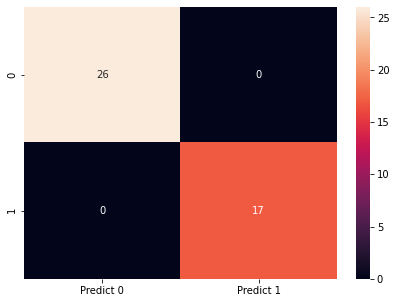

In [502]:
## Comparison of Actual ('Quality') and Precicted ('Kmean Group' , 'Hierr Group') classes

print("Confusion Matrix")
cm=metrics.confusion_matrix(raw_data['Quality'],wine_['Kmean Group'], labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["0","1"]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)


Confusion Matrix


0     26
-1    18
1     17
Name: Quality, dtype: int64

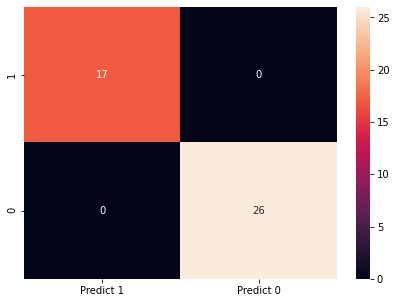

In [503]:
print("Confusion Matrix")
cm=metrics.confusion_matrix(raw_data['Quality'],wine_['Hierr Group'], labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True)

raw_data['Quality'].value_counts()

#### Comment
* Since the predictions for the groups are perfect, we can go ahead and replace the data 

In [504]:
# Finalizing new dataset
wine_.head(5)

A    B    C    D  Kmean Group  Hierr Group
0   47   27   45  108            0            0
1  174  133  134  166            1            1
2  159  163  135  131            1            1
3   61   23    3   44            0            0
4   59   60    9   68            0            0

In [505]:
wine_ = wine_.drop(["Hierr Group"],axis=1)
wine_ = wine_.rename(columns={'Kmean Group': 'Quality'})
wine_.to_csv("Wine Raw Data")
wine_.head(5)

A    B    C    D  Quality
0   47   27   45  108        0
1  174  133  134  166        1
2  159  163  135  131        1
3   61   23    3   44        0
4   59   60    9   68        0

In [506]:
wine_

A    B    C    D  Quality
0    47   27   45  108        0
1   174  133  134  166        1
2   159  163  135  131        1
3    61   23    3   44        0
4    59   60    9   68        0
..  ...  ...  ...  ...      ...
56  200  186  185  179        1
57  137  182  165  199        1
58   88   39    9  102        0
59  180  157  192  198        1
60  157  135  135  156        1

[61 rows x 5 columns]

#### Comment :
* The predicted clusters are appended as the new Quality column in the original data 

# Part 3 : Automobile data - Dimensionality reduction and SVM Classifier

### Data - Import, Clean and Pre-process

In [507]:
vehicle_data = pd.read_csv("Part3 - vehicle.csv")
vehicle_data.head(5)

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [508]:
vehicle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [509]:
vehicle_data=vehicle_data.dropna()

###  EDA and Visualization

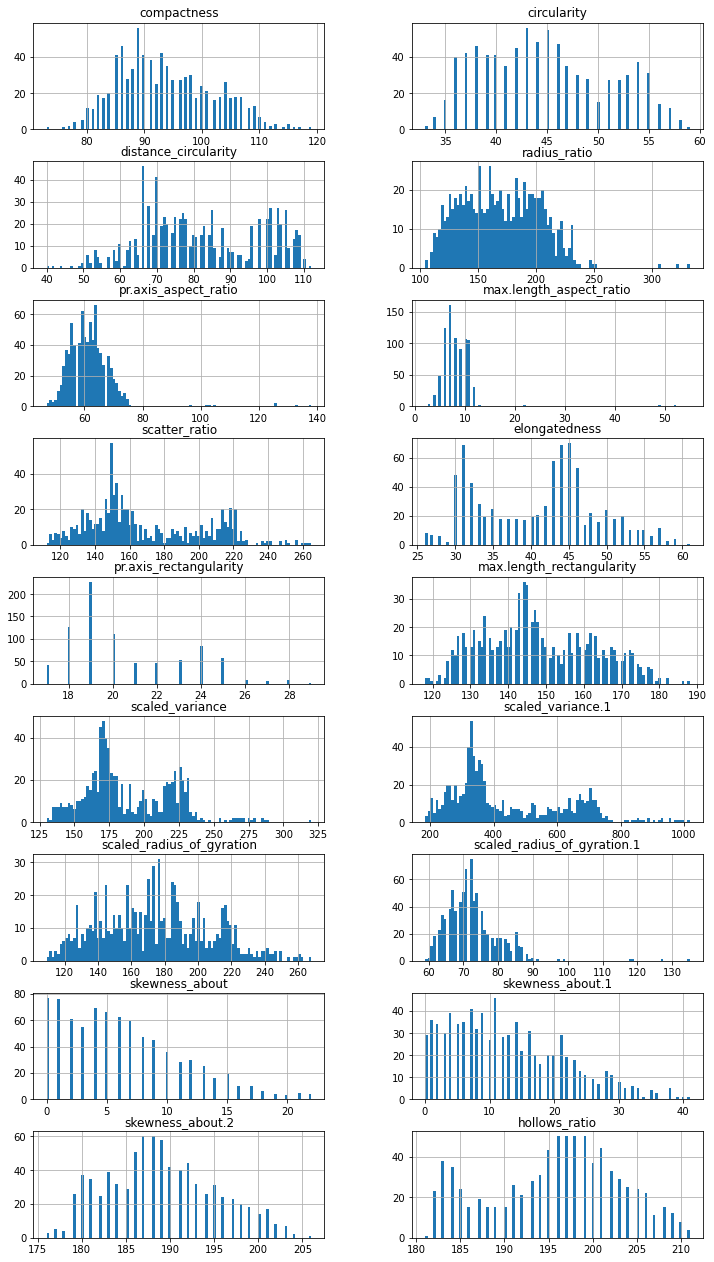

In [510]:
# Histogram of continuous columns
columns = list(vehicle_data)[0:-1] # Excluding Outcome column which is a category
vehicle_data[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(12,2)); 

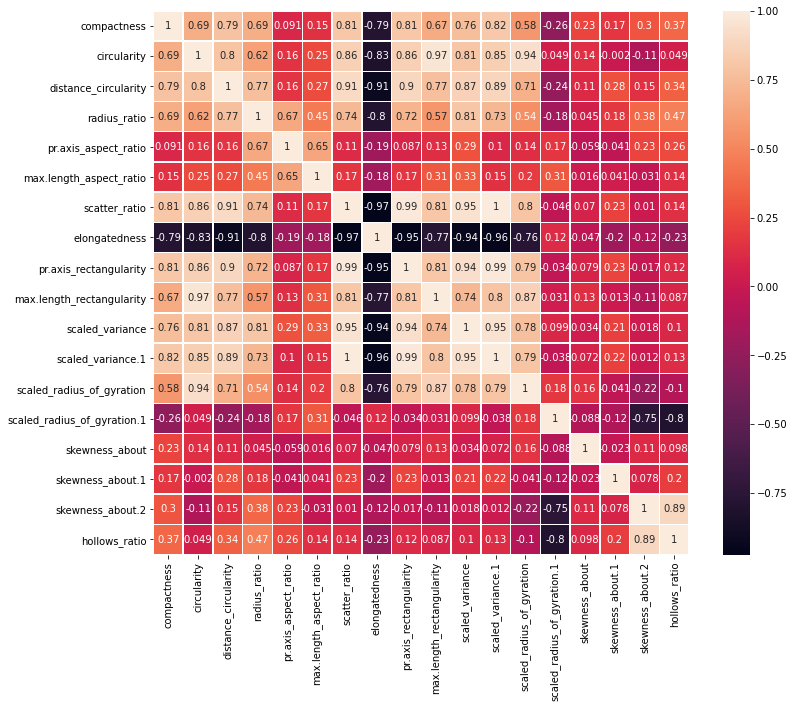

In [511]:
# Getting the correlation matrix 
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.heatmap(vehicle_data.corr(), annot = True, linewidth=0.5)
plt.show()

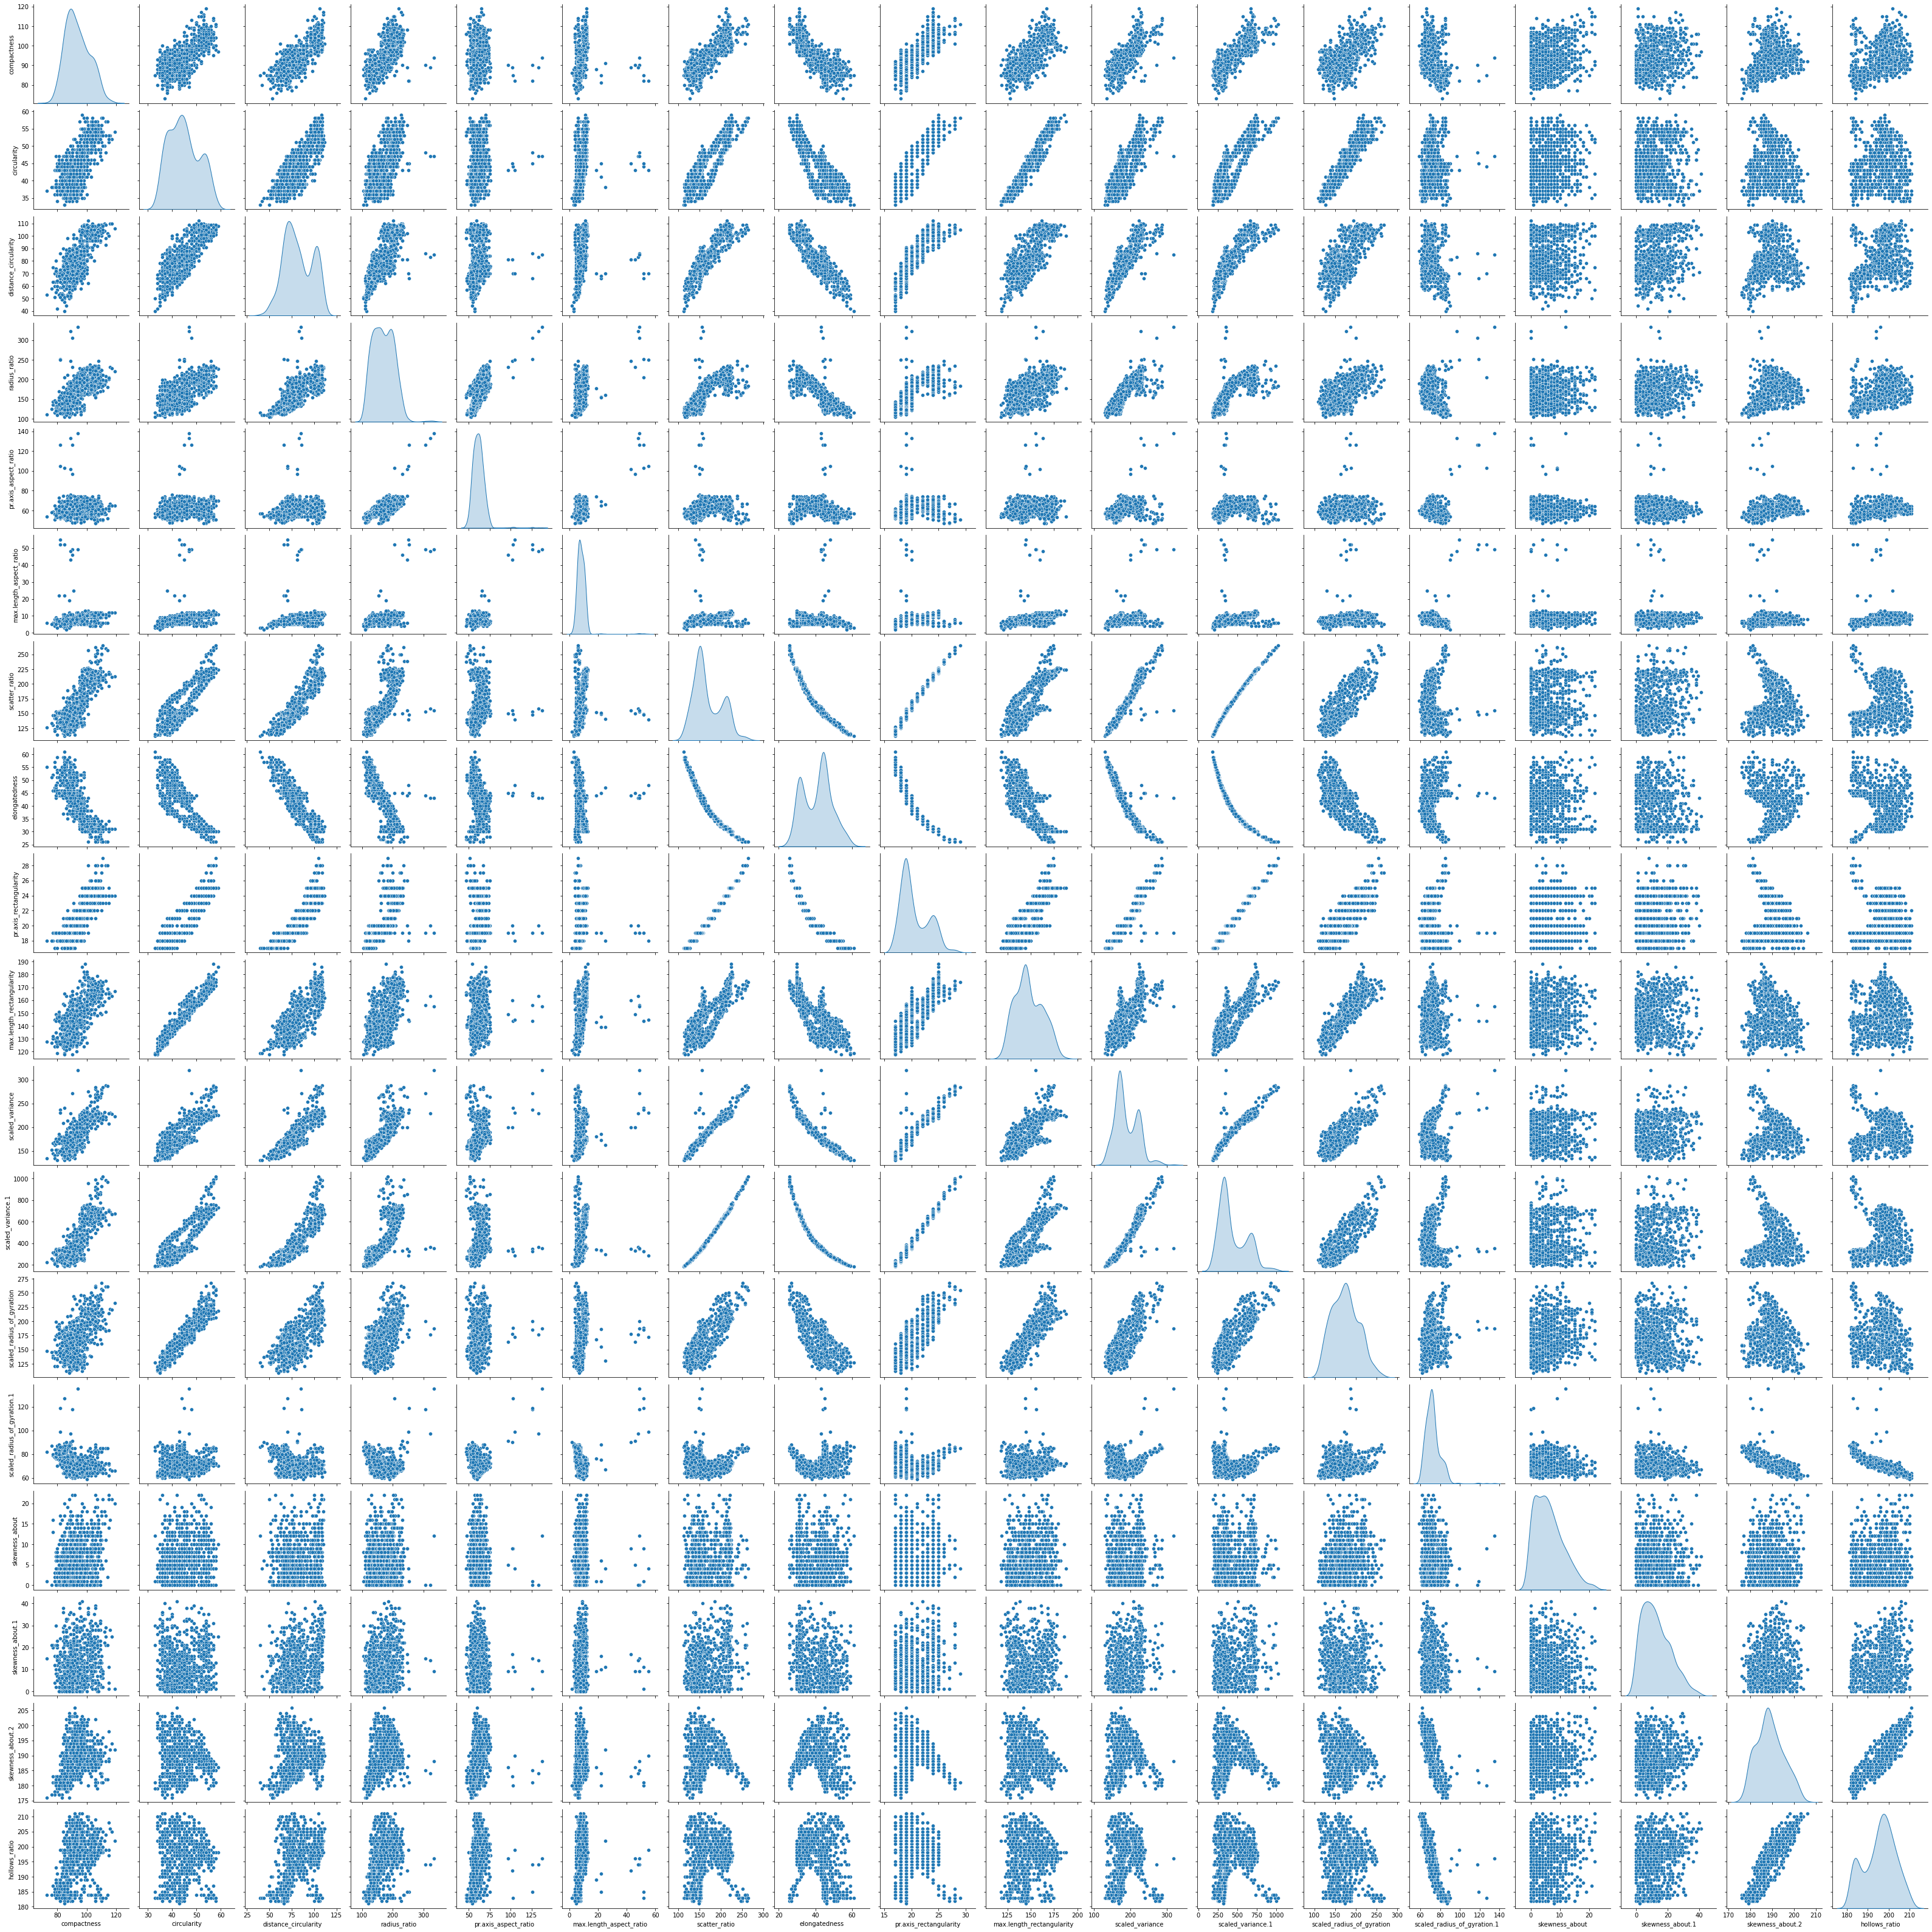

In [512]:
sns.pairplot(vehicle_data[columns],diag_kind='kde')

#### Comments:
* Linear correlation is visible in many parameters
* Elongatedness has maximum negative correlation with maximum number of independent variables

### SVM Classifier

In [513]:
#Segregate predictors vs target attributes

X = vehicle_data.loc[:, vehicle_data.columns != 'class']  
y = vehicle_data['class']

In [514]:
y.value_counts()

car    413
bus    205
van    195
Name: class, dtype: int64

In [515]:
# Up-sample the minority data almost equal to majority count
from sklearn.utils import resample
# Separate majority and minority classes
df_car = vehicle_data[y=='car']
df_bus = vehicle_data[y=='bus']
df_van = vehicle_data[y=='van']

In [516]:
# Upsample minority class
df_bus_upsampled = resample(df_bus, 
                                 replace=True,     # sample with replacement
                                 n_samples=400,    # to match majority class
                                 random_state=77) # reproducible results
df_van_upsampled = resample(df_van, 
                                 replace=True,     # sample with replacement
                                 n_samples=400,    # to match majority class
                                 random_state=77) # reproducible results
# Upsample minority class
df_bus_upsampled = resample(df_bus, 
                                 replace=True,     # sample with replacement
                                 n_samples=400,    # to match majority class
                                 random_state=77) # reproducible results
df_van_upsampled = resample(df_van, 
                                 replace=True,     # sample with replacement
                                 n_samples=400,    # to match majority class
                                 random_state=77) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_car, df_bus_upsampled, df_van_upsampled])
 
# Display new class counts
df_upsampled['class'].value_counts()

car    413
bus    400
van    400
Name: class, dtype: int64

In [517]:
#Segregate predictors vs target attributes

X = df_upsampled.loc[:, df_upsampled.columns != 'class']  
y = df_upsampled['class']

y.value_counts()

car    413
bus    400
van    400
Name: class, dtype: int64

In [518]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=11,stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [519]:
parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']},
]

In [520]:
# Create a classifier object with the classifier and parameter candidates
clf_test = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf_test.fit(X_train_scaled, y_train)  

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']}])

In [521]:
# View the accuracy score
print('Best score for data:', clf_test.best_score_) 

# View the best parameters for the model found using grid search
print('Best C:',clf_test.best_estimator_.C) 
print('Best Kernel:',clf_test.best_estimator_.kernel)
print('Best Gamma:',clf_test.best_estimator_.gamma)

Best score for data: 0.9846989209885137
Best C: 1000
Best Kernel: rbf
Best Gamma: 0.1


In [522]:
clf2 = svm.SVC(C=1000, kernel='rbf',gamma=0.1)
clf2.fit(X_train_scaled, y_train)
print("Accuracy on training set: {:.2f}".format(clf2.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.2f}".format(clf2.score(X_test_scaled, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.99


#### Comment : It is quite evident that the model overfits because of the ideal train score

In [523]:
y_pred = clf2.predict(X_test_scaled)

<AxesSubplot:>

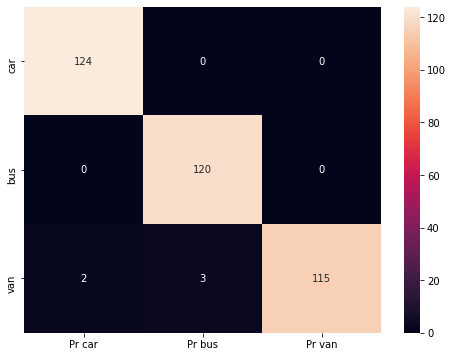

In [524]:
lab= ["car","bus","van"]
plab=["Pr "+s for s in lab]

cm=metrics.confusion_matrix(y_test, y_pred, labels=lab)

df_cm = pd.DataFrame(cm, index = [i for i in lab],
                  columns = [i for i in plab])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True ,fmt='g')

### Dimensionality reduction using PCA

In [525]:
X = df_upsampled.drop(['class'], axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(1213, 18)

In [526]:
covMatrix = np.cov(X_scaled,rowvar=False)
pca = PCA(n_components=18)
pca.fit(X_scaled)

PCA(n_components=18)

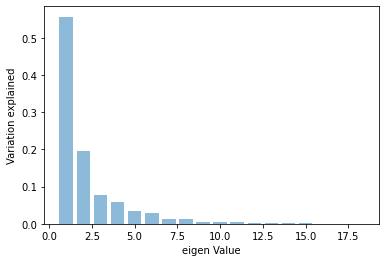

In [527]:
plt.bar(list(range(1,19)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

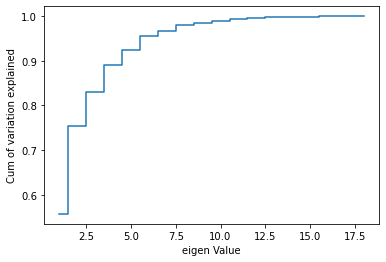

In [528]:
plt.step(list(range(1,19)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

#### Comment : 95% of variables data is expalined by 6 pca, so we proceed with number of components = 6

In [529]:
pca6 = PCA(n_components=6)
pca6.fit(X_scaled)
print(pca6.components_)
print(pca6.explained_variance_ratio_)
Xpca6 = pca6.transform(X_scaled)

[[ 0.22532628  0.32116429  0.31427755  0.19294088  0.03142044  0.03133673
   0.33989662 -0.34266019  0.35578546  0.26331886  0.29860257  0.32882153
   0.26634125 -0.00627144  0.04254386  0.07472038  0.01441928  0.0581792 ]
 [ 0.13118659 -0.11692524  0.09205613  0.15318339  0.06752931  0.0070202
  -0.03409395 -0.02374818 -0.04928705 -0.08453477 -0.03963314 -0.03123568
  -0.18226591 -0.26009186  0.10624788  0.09029293  0.57267245  0.68589914]
 [ 0.07580669  0.1989637  -0.04427293 -0.09400598 -0.05656325 -0.02974834
  -0.07296406  0.09692049 -0.06737818  0.18754493 -0.1188789  -0.06442839
   0.18776542 -0.04818826  0.73644488 -0.53394224  0.04370105  0.01177365]
 [ 0.10058775 -0.17289181  0.04758372 -0.15865441 -0.21014844 -0.14101399
   0.06395572  0.01565126  0.09135365 -0.15561809 -0.02147345  0.0723234
  -0.11745881 -0.01638127  0.57637753  0.67171745 -0.10275974 -0.13370992]
 [-0.17540154  0.05649735 -0.01122705  0.37524006  0.50450301  0.49922382
  -0.13222484  0.10062123 -0.1513160

### SVM Classifier with new columns generated using PCA

In [530]:
vehicle_columns = pd.DataFrame(Xpca6)

In [531]:
#Segregate predictors vs target attributes
X = vehicle_columns 
y = df_upsampled['class']

X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,test_size = 0.3, random_state=11,stratify=y)
y_train1.value_counts()

car    289
bus    280
van    280
Name: class, dtype: int64

In [532]:
clf3 = svm.SVC(C=1000, kernel='rbf',gamma=0.1) 
clf3.fit(X_train1 , y_train1)

print("Accuracy on training set: {:.2f}".format(clf3.score(X_train1, y_train1)))
print("Accuracy on test set: {:.2f}".format(clf3.score(X_test1, y_test1)))

Accuracy on training set: 0.91
Accuracy on test set: 0.88


In [533]:
y_pred1=clf3.predict(X_test1)

<AxesSubplot:>

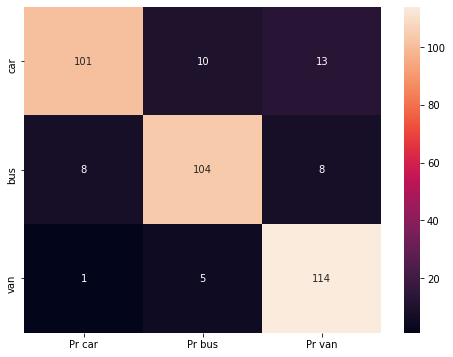

In [534]:
lab= ["car","bus","van"]
plab=["Pr "+s for s in lab]

cm=metrics.confusion_matrix(y_test1, y_pred1, labels=lab)

df_cm = pd.DataFrame(cm, index = [i for i in lab],
                  columns = [i for i in plab])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True ,fmt='g')

#### Comment : 
* The modified model has more resonable train and test score
* 18 features contributing ti the curse of dimensionality reduced to just 6
* 95% of the data is still expalined with just 6 variables

# Part 4 : Data driven batsmen ranking model

In [535]:
# Importing raw data and previewing it
sports_data = pd.read_csv("Part4 - batting_bowling_ipl_bat.csv")
sports_data.head(10)

Name   Runs    Ave      SR  Fours  Sixes   HF
0        NaN    NaN    NaN     NaN    NaN    NaN  NaN
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0
2        NaN    NaN    NaN     NaN    NaN    NaN  NaN
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0
4        NaN    NaN    NaN     NaN    NaN    NaN  NaN
5   V Sehwag  495.0  33.00  161.23   57.0   19.0  5.0
6        NaN    NaN    NaN     NaN    NaN    NaN  NaN
7   CL White  479.0  43.54  149.68   41.0   20.0  5.0
8        NaN    NaN    NaN     NaN    NaN    NaN  NaN
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0

In [536]:
sports_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 10.0+ KB


In [537]:
data=sports_data.dropna()

In [538]:
data.Name.unique()

array(['CH Gayle', 'G Gambhir', 'V Sehwag', 'CL White', 'S Dhawan',
       'AM Rahane', 'KP Pietersen', 'RG Sharma', 'AB de Villiers',
       'JP Duminy', 'DA Warner', 'SR Watson', 'F du Plessis', 'OA Shah',
       'DJ Bravo', 'DJ Hussey', 'SK Raina', 'AT Rayudu', 'Mandeep Singh',
       'R Dravid', 'DR Smith', 'M Vijay', 'SPD Smith', 'TM Dilshan',
       'RV Uthappa', 'SE Marsh', 'KA Pollard', 'DMD Jayawardene',
       'V Kohli', 'MA Agarwal', 'SR Tendulkar', 'MEK Hussey', 'JH Kallis',
       'MS Dhoni', 'MS Bisla', 'JD Ryder', 'BJ Hodge', 'NV Ojha',
       'DB Das', 'AC Gilchrist', 'BB McCullum', 'IK Pathan',
       'Azhar Mahmood', 'MK Pandey', 'S Badrinath', 'DA Miller',
       'MK Tiwary', 'JA Morkel', 'LRPL Taylor', 'M Manhas',
       'DT Christian', 'RA Jadeja', 'JEC Franklin', 'KC Sangakkara',
       'Y Nagar', 'STR Binny', 'SS Tiwary', 'KD Karthik', 'AL Menaria',
       'PA Patel', 'SC Ganguly', 'YK Pathan', 'Harbhajan Singh',
       'RE Levi', 'LR Shukla', 'Y Venugopal Rao', 

In [539]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


### Univariate Analysis

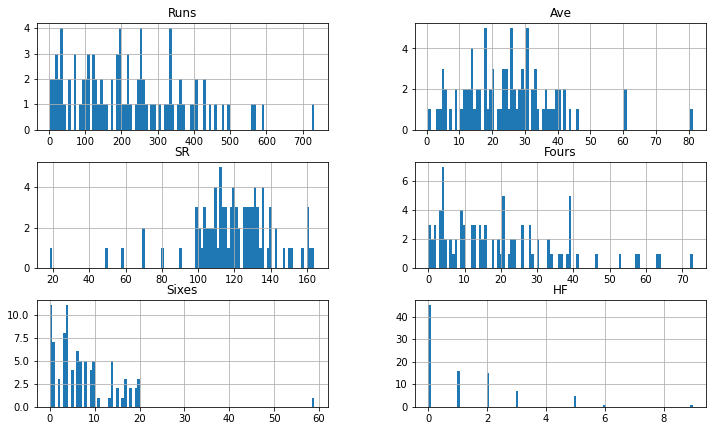

In [540]:
# Histogram of continuous columns
columns = list(data)[1:] 
data[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(12,2)); 

<AxesSubplot:>

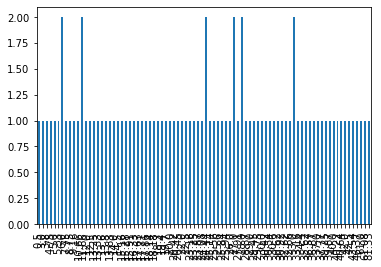

In [541]:
data['Ave'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

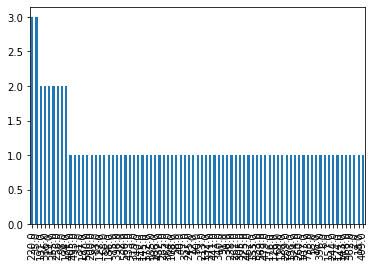

In [542]:
data['Runs'].value_counts().head(100).plot.bar()

### Bivariate Analysis

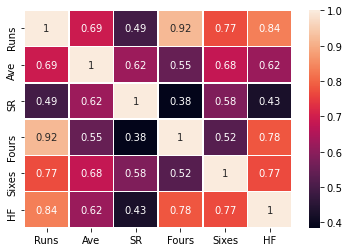

In [543]:
# Getting the correlation matrix 
ax = sns.heatmap(data.corr(), annot = True, linewidth=0.5)
plt.show()

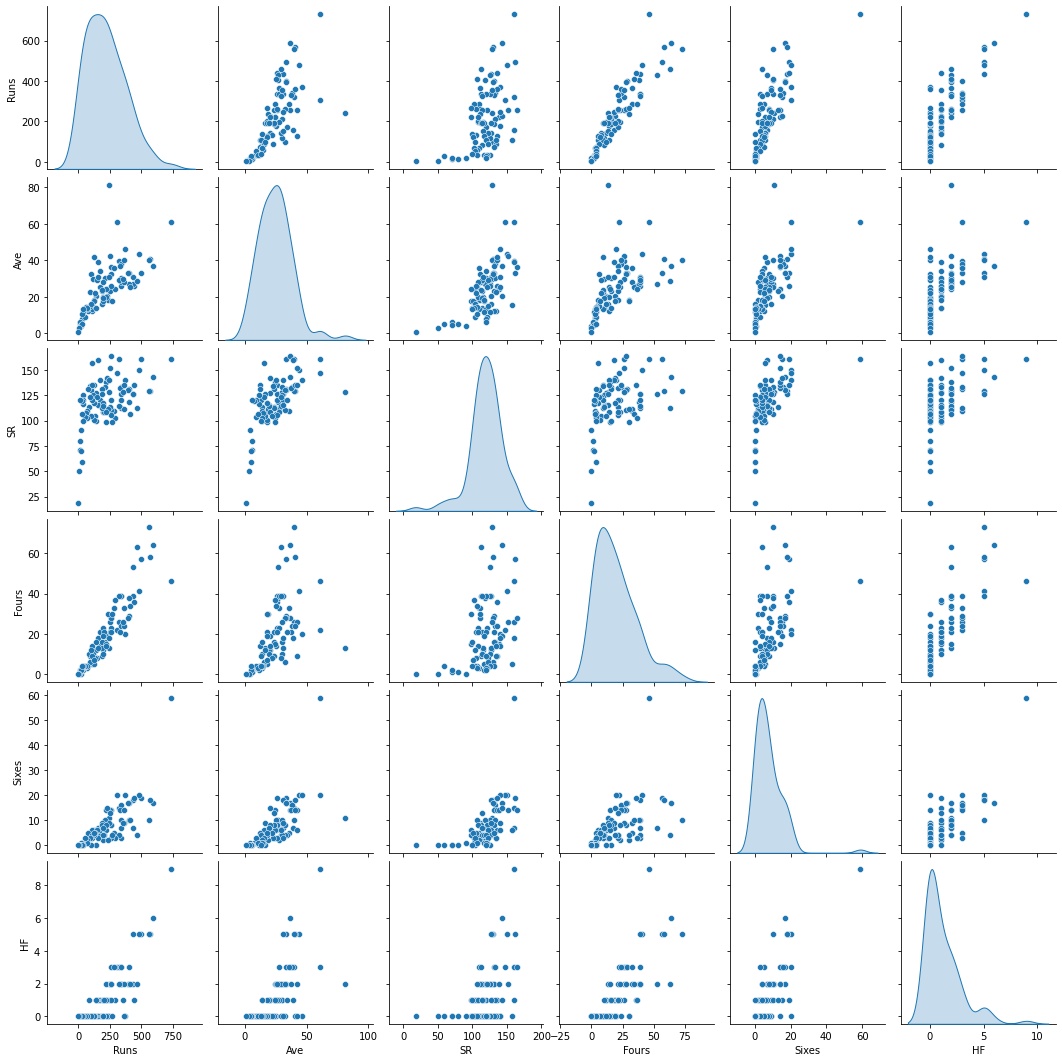

In [544]:
# Pair plot of all continuous variables
sns.pairplot(data[columns],diag_kind='kde')

In [545]:
#dropping/ignoring player name  and origin
cData = data.drop(['Name'], axis=1)
cData.head()

Runs    Ave      SR  Fours  Sixes   HF
1  733.0  61.08  160.74   46.0   59.0  9.0
3  590.0  36.87  143.55   64.0   17.0  6.0
5  495.0  33.00  161.23   57.0   19.0  5.0
7  479.0  43.54  149.68   41.0   20.0  5.0
9  569.0  40.64  129.61   58.0   18.0  5.0

In [546]:
XScaled=cData.apply(zscore)
XScaled.head()

Runs       Ave        SR     Fours     Sixes        HF
1  3.301945  2.683984  1.767325  1.607207  6.462679  4.651551
3  2.381639  0.896390  1.036605  2.710928  1.184173  2.865038
5  1.770248  0.610640  1.788154  2.281703  1.435530  2.269533
7  1.667276  1.388883  1.297182  1.300618  1.561209  2.269533
9  2.246490  1.174755  0.444038  2.343021  1.309851  2.269533

In [547]:
covMatrix = np.cov(XScaled,rowvar=False)
print(covMatrix)

[[1.01123596 0.70077082 0.49903347 0.9291323  0.77842677 0.84453142]
 [0.70077082 1.01123596 0.63061271 0.55234856 0.69008186 0.62772842]
 [0.49903347 0.63061271 1.01123596 0.38913406 0.59050396 0.43238784]
 [0.9291323  0.55234856 0.38913406 1.01123596 0.52844526 0.79249429]
 [0.77842677 0.69008186 0.59050396 0.52844526 1.01123596 0.77632221]
 [0.84453142 0.62772842 0.43238784 0.79249429 0.77632221 1.01123596]]


In [548]:
pca = PCA(n_components=6)
pca.fit(XScaled)

PCA(n_components=6)

In [549]:
#eigen values
Eigen_values = pca.explained_variance_

In [550]:
#eigen vectors
Eigen_vectors = pca.components_

In [551]:
print(pca.explained_variance_ratio_)

[0.70911996 0.13784566 0.06867133 0.05424458 0.02730624 0.00281223]


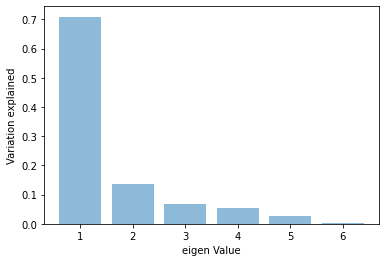

In [552]:
plt.bar(list(range(1,7)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

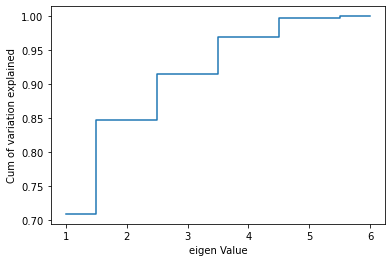

In [553]:
plt.step(list(range(1,7)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

#### Comment : All the PCAs are used for score calculation

In [554]:
Score_PC0 = Eigen_values[0] * Eigen_vectors[0]
Score_PC1 = Eigen_values[1] * Eigen_vectors[1]
Score_PC2 = Eigen_values[2] * Eigen_vectors[2]
Score_PC3 = Eigen_values[3] * Eigen_vectors[3]
Score_PC4 = Eigen_values[4] * Eigen_vectors[4]
Score_PC5 = Eigen_values[5] * Eigen_vectors[5]

In [555]:
Score_PC = Score_PC0 + Score_PC1 + Score_PC2 + Score_PC3 + Score_PC4 + Score_PC5
Score_PC

array([2.23503646, 1.69872936, 0.46763194, 1.92536622, 1.90217094,
       2.02382426])

In [556]:
C_Data = data.copy()

In [557]:
C_Data['Score'] = C_Data['Runs']*Score_PC[0] + C_Data['Ave']*Score_PC[1] + C_Data['SR']*Score_PC[2] + C_Data['Fours']*Score_PC[3] + C_Data['Sixes']*Score_PC[4] + C_Data['HF']*Score_PC[5]

In [558]:
C_Data = C_Data.sort_values(by = 'Score',  ascending = False)
C_Data.head(3)

Name   Runs    Ave      SR  Fours  Sixes   HF        Score
1   CH Gayle  733.0  61.08  160.74   46.0   59.0  9.0  2036.216624
3  G Gambhir  590.0  36.87  143.55   64.0   17.0  6.0  1616.135519
9   S Dhawan  569.0  40.64  129.61   58.0   18.0  5.0  1557.411323

### Comment : Based on the scores, the top 3 players are as shown in the table above
* Rank 1 : CH Gayle
* Rank 2 : G Gambhir
* Rank 3 : S Dhawan

# Part 5 : Question Based

## Dimensionality Reduction Techniques

* Missing Value Ratio
* Low Variance Filter
* High Correlation Filter
* Random Forest
* Backward Feature Elimination
* Forward Feature Selection
* Factor Analysis
* Principal Component Analysis
* Independent Component Analysis
* Methods Based on Projections
* t-Distributed Stochastic Neighbor Embedding (t-SNE)
* Uniform Manifold Approximation and Projection - UMAP

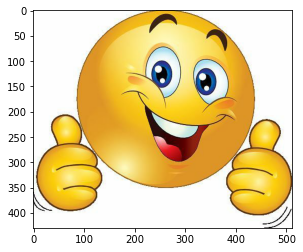

In [559]:
import matplotlib.image as mpimg
from PIL import Image
image = mpimg.imread('Smiley_Image.jpg')
imgplot = plt.imshow(image)

In [560]:
image = image/255.0

In [561]:
img2 = image.reshape(-1,3)

In [562]:
img2.shape

(220160, 3)

In [563]:
km = KMeans(n_clusters=4)
km.fit(img2)
img_seg = km.cluster_centers_
img_seg = img_seg[km.labels_]
img_seg = img_seg.reshape(image.shape)

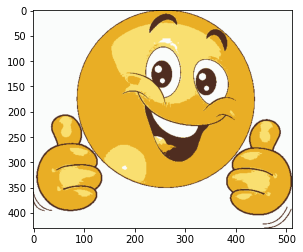

In [564]:
plt.imshow(img_seg)

In [565]:
# PCA on image

In [566]:
image.shape

(430, 512, 3)

In [567]:
img_pca = image.reshape(430,512*3)

In [568]:
pca_dims = PCA()
pca_dims.fit(img_pca)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [569]:
d

68

In [570]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(img_pca)
X_recovered = pca.inverse_transform(X_reduced)

In [571]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (430, 68)
recovered shape: (430, 1536)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


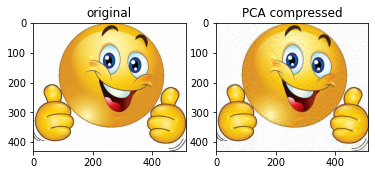

In [572]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(img_pca.reshape((image.shape)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered.reshape((image.shape)))
plt.show(block=True)

### Comments : The original image is retained with reduced features as well